## Домашнее задание: Разработка рекомендательной системы для музыки на платформе Spotify

1. Предобработка данных и EDA

Необходимо провести анализ данных (Exploratory Data Analysis, EDA) для понимания структуры датасетов и подготовки данных к разработке рекомендательной системы: 
- Загрузка данных и очистка выбросов
- Рассчитайте основные статистики для числовых колонок: среднее, медиану, стандартное отклонение, минимумы и максимумы.
- Проведите корреляционный анализ между различными признаками (например, между valence, energy, danceability и другими признаками).
- Постройте гистограммы и коробочные диаграммы для визуализации распределений числовых признаков.
- Анализ категориальных данных
- Постройте тепловую карту корреляции между признаками.

2. Разработка рекомендательной системы (Контентная фильтрация)

В этой части задания необходимо разработать рекомендательную систему, которая будет основывать свои рекомендации на характеристиках самих песен.

- Построение модели на основе контента. Используйте признаки, чтобы рекомендовать похожие песни по жанрам и стилю.
- Проведите кластеризацию для улучшения рекомендация на основе признаков с использованием алгоритмов, таких как K-means или DBSCAN. Рекомендуйте песни, которые находятся в одном кластере с уже выбранной песней.

3. Построение гибридной модели

    Разработайте гибридную рекомендательную систему, которая сочетает контентную фильтрацию и методы кластеризации признаков. Таким образом, рекомендации могут быть основаны как на схожести признаков, так и на принадлежности песен к определённым группам (кластерам).

4. Оценка качества модели

После того как модели будут построены, необходимо провести их оценку.

- Придумайте метрику для оценки качества на тренировочных данных.
- Создайте свой валидационный набор в группе студентов. Каждому из студентов необходимо выбрать по 30 песен, которые ему нравятся. Желательно разных исполнителей. Объедините данные в группе и создайте единый набор.
- Оцените свою модель с помощью метрик precision/recall at K на разных параметрах и объясните полученный результат. 

In [1]:
import sys
import os
import pandas as pd
import numpy as np
from scipy import sparse
import random
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
# Загрузка полного набора песен
songs_df = pd.read_csv('spotify_dataset/data.csv')

# Загрузка предпочтений пользователей
user_pref_df = pd.read_csv('spotify_dataset/users_preference_data.csv')

# Разделим мета-информацию (пользовательские данные) и саму песню
user_meta_df = user_pref_df.iloc[:, :3]    
user_songs_df = user_pref_df.iloc[:, 3:]   

user_pref_df = pd.concat([user_meta_df, user_songs_df], axis=1)

user_id = 1
user_liked_songs = user_pref_df[user_pref_df['user_ID'] == user_id]

print("Песни, которые нравятся пользователю:")
print(user_liked_songs)


Песни, которые нравятся пользователю:
    Unnamed: 0  user_ID      user_name  valence  year  acousticness  \
0        17491        1  Дмитрий Навой   0.7620  2009      0.063100   
1        17730        1  Дмитрий Навой   0.6630  2010      0.002490   
2        50264        1  Дмитрий Навой   0.1980  1985      0.458000   
3        50801        1  Дмитрий Навой   0.6490  1988      0.029300   
4        52026        1  Дмитрий Навой   0.2300  1994      0.305000   
5        66550        1  Дмитрий Навой   0.4750  1977      0.005020   
6        66692        1  Дмитрий Навой   0.5630  1978      0.437000   
7        67718        1  Дмитрий Навой   0.7230  1983      0.052100   
8        67857        1  Дмитрий Навой   0.4190  1984      0.444000   
9        82033        1  Дмитрий Навой   0.9390  1968      0.025100   
10       84918        1  Дмитрий Навой   0.7360  1983      0.815000   
11       85983        1  Дмитрий Навой   0.8890  1988      0.050000   
12       89995        1  Дмитрий Навой 

In [3]:
import pandas as pd

numeric_cols = songs_df.select_dtypes(include='number')

eda_stats = numeric_cols.describe().T
eda_stats['median'] = numeric_cols.median()

eda_stats = eda_stats[['mean', 'median', 'std', 'min', '25%', '50%', '75%', 'max']]
print(eda_stats)

                           mean         median            std     min  \
valence                0.528587       0.540000       0.263171     0.0   
year                1976.787241    1977.000000      25.917853  1921.0   
acousticness           0.502115       0.516000       0.376032     0.0   
danceability           0.537396       0.548000       0.176138     0.0   
duration_ms       230948.310666  207467.000000  126118.414668  5108.0   
energy                 0.482389       0.471000       0.267646     0.0   
explicit               0.084575       0.000000       0.278249     0.0   
instrumentalness       0.167010       0.000216       0.313475     0.0   
key                    5.199844       5.000000       3.515094     0.0   
liveness               0.205839       0.136000       0.174805     0.0   
loudness             -11.467990     -10.580000       5.697943   -60.0   
mode                   0.706902       1.000000       0.455184     0.0   
popularity            31.431794      33.000000     

 # Возможные проблемы:
- Выбросы в duration_ms — стоит рассмотреть логарифм или фильтрацию значений >1 млн мс.
- Некоторые поля (tempo, speechiness, loudness) имеют очень широкий диапазон — может потребоваться нормализация перед обучением моделей.

In [4]:

# songs_df = songs_df[songs_df['duration_ms'] < 1_000_000]   # отсекаем > ~17 мин
songs_df['duration_ms'] = np.log1p(songs_df['duration_ms'])    # логарифм

#### По хорошему нужно удалить, но тогда сбрасываются все индексы, которые указывали ребята(((


Корреляционная матрица:
                   valence      year  acousticness  danceability  duration_ms  \
valence           1.000000 -0.028245     -0.184101      0.558946    -0.181197   
year             -0.028245  1.000000     -0.614250      0.188515     0.190907   
acousticness     -0.184101 -0.614250      1.000000     -0.266852    -0.172892   
danceability      0.558946  0.188515     -0.266852      1.000000    -0.097436   
duration_ms      -0.181197  0.190907     -0.172892     -0.097436     1.000000   
energy            0.353876  0.530272     -0.749393      0.221967     0.131767   
explicit         -0.018613  0.220881     -0.246007      0.241757    -0.051935   
instrumentalness -0.198501 -0.272371      0.329819     -0.278063     0.020187   
key               0.028473  0.007540     -0.020550      0.024439    -0.003705   
liveness          0.003832 -0.057318     -0.024482     -0.100193     0.005056   
loudness          0.313512  0.487697     -0.561696      0.285057     0.112851   
mod

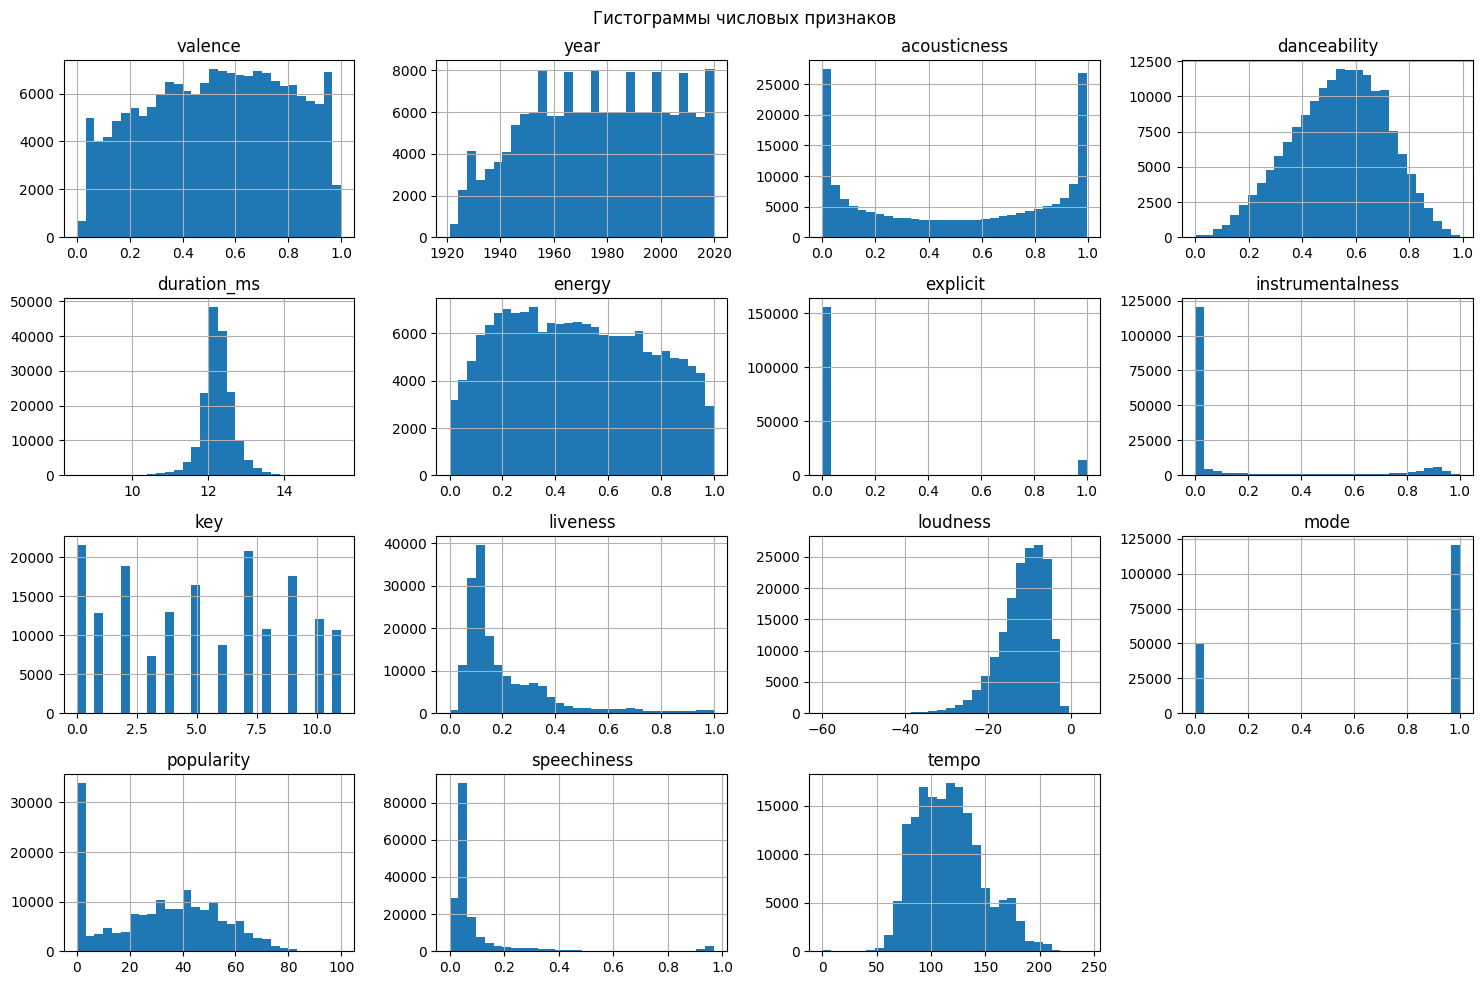

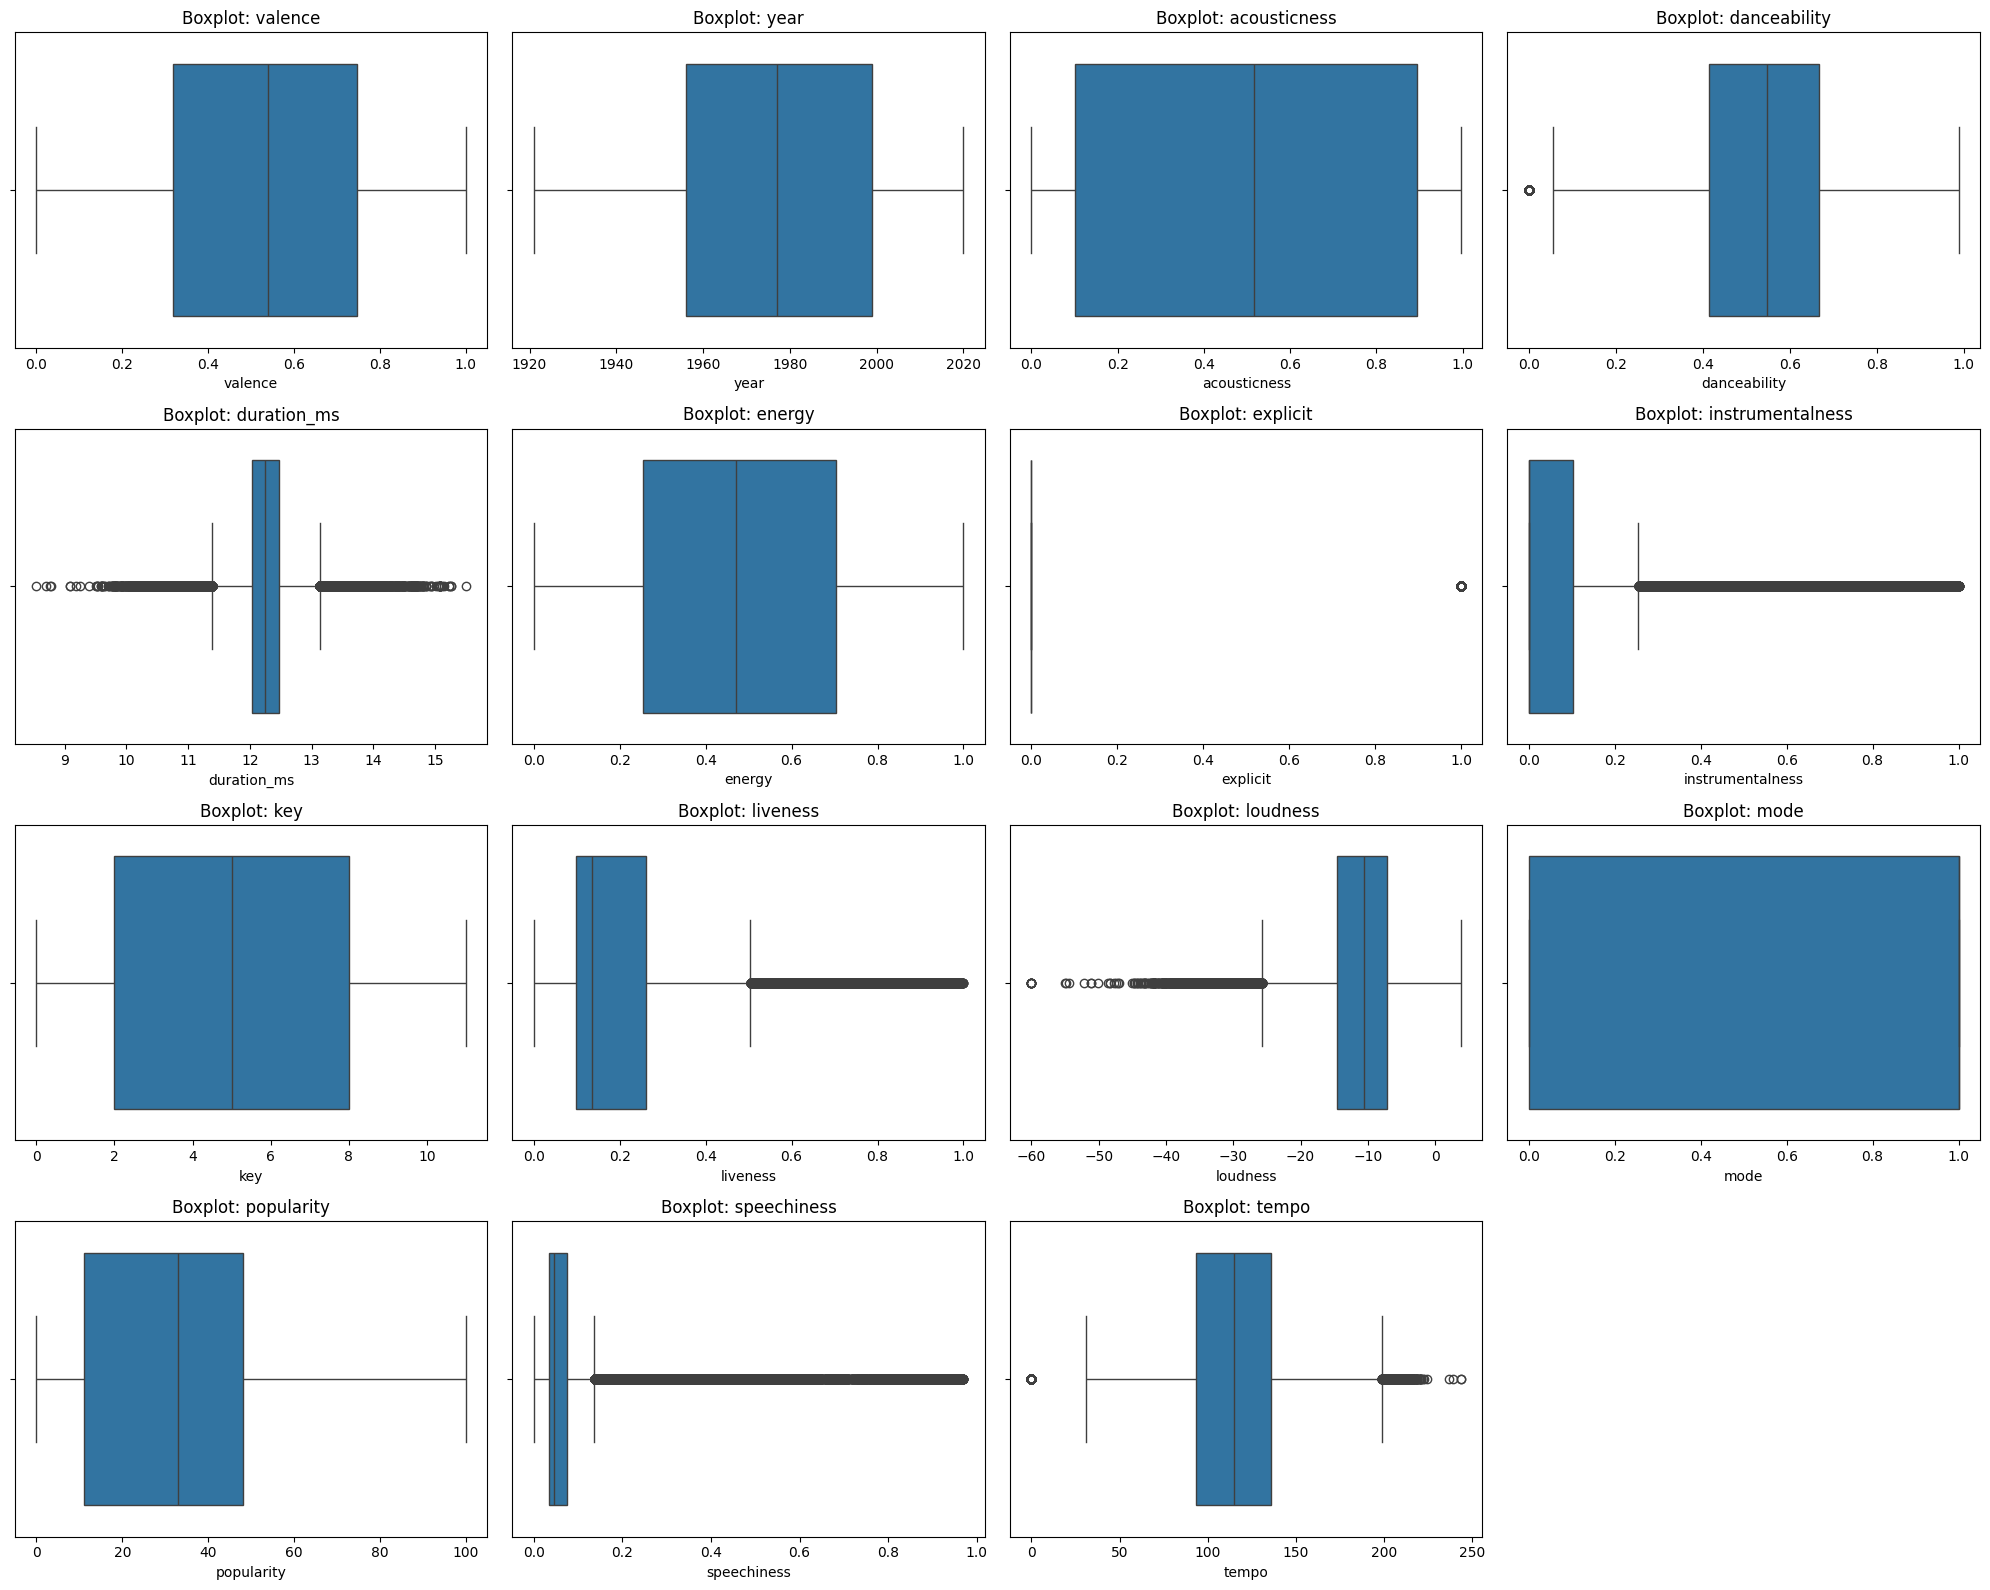


Категориальные признаки:
               count  unique                     top  freq
artists       170653   34088    ['Эрнест Хемингуэй']  1211
id            170653  170653  4BJqT0PrAfrxzMOxytFOIz     1
name          170653  133638         White Christmas    73
release_date  170653   11244                    1945  1446


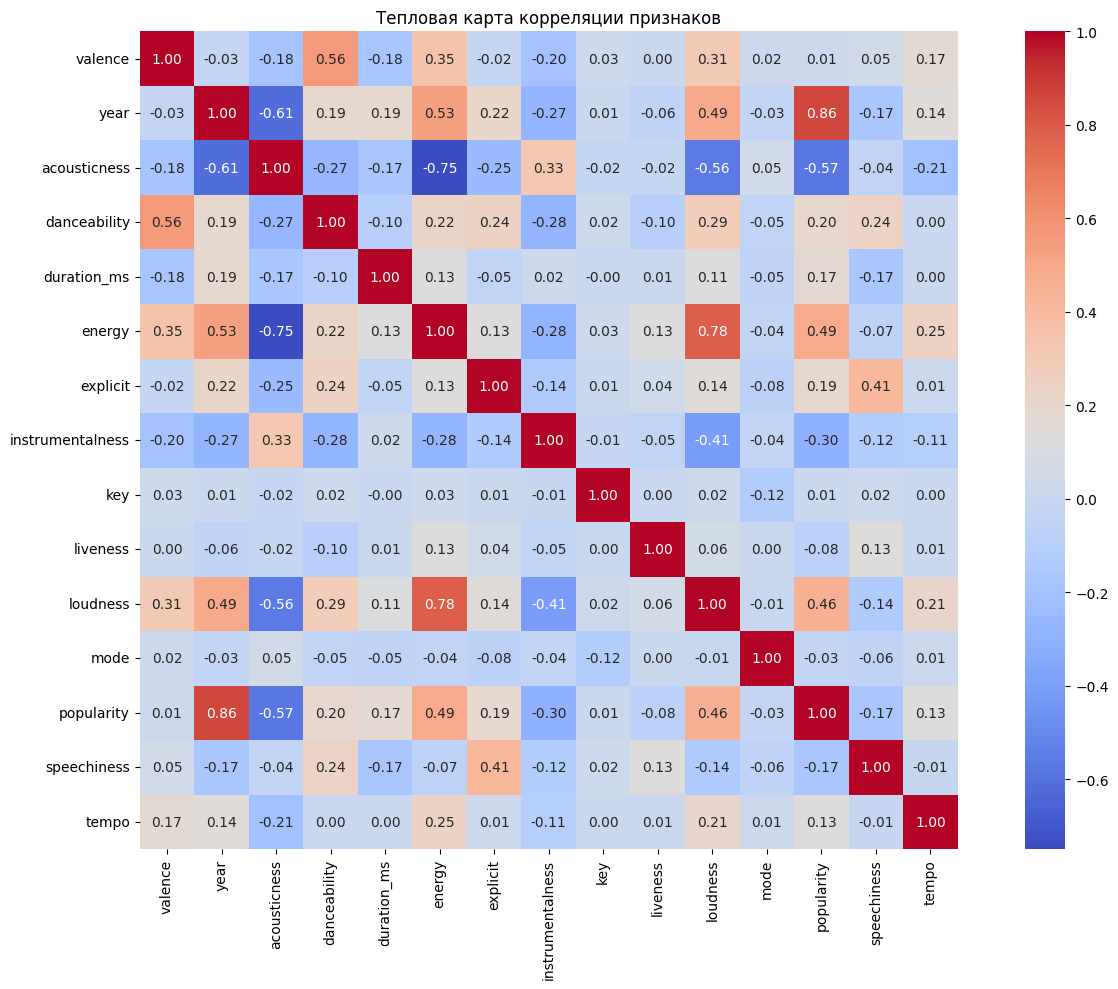

In [5]:
# 1. Корреляционный анализ числовых признаков
numeric_cols = songs_df.select_dtypes(include='number')
correlation_matrix = numeric_cols.corr()
print("\nКорреляционная матрица:")
print(correlation_matrix)

# 2. Визуализация распределения — гистограммы
numeric_cols.hist(bins=30, figsize=(15, 10))
plt.suptitle('Гистограммы числовых признаков')
plt.tight_layout()
plt.show()

# 2. Визуализация распределения — boxplot
n_features = len(numeric_cols.columns)
cols = 4
rows = math.ceil(n_features / cols)
plt.figure(figsize=(5 * cols, 4 * rows))
for i, column in enumerate(numeric_cols.columns):
    plt.subplot(rows, cols, i + 1)
    sns.boxplot(x=songs_df[column])
    plt.title(f'Boxplot: {column}')
plt.tight_layout()
plt.show()

# 3. Анализ категориальных данных
categorical_cols = songs_df.select_dtypes(include='object')
if not categorical_cols.empty:
    print("\nКатегориальные признаки:")
    print(categorical_cols.describe().T)
else:
    print("\nКатегориальные признаки отсутствуют.")

# 4. Тепловая карта корреляции
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Тепловая карта корреляции признаков")
plt.tight_layout()
plt.show()

### **1. Корреляционный анализ**

#### Сильные положительные корреляции:
- energy — loudness: 0.78 — логично, чем громче трек, тем он энергичнее.
- popularity — year: 0.86 — новее трек → чаще популярен (возможно, эффект свежести или неполные данные по старым песням).
- danceability — valence: 0.56 — веселые треки чаще танцевальные.
- energy — popularity: 0.49 — популярные треки, как правило, более энергичные.

#### Сильные отрицательные корреляции:
- acousticness — energy: -0.75 — чем выше акустичность, тем ниже энергия (вокал и акустика мягче звучат).

#### Слабые связи:
- explicit, mode, key — почти не влияют на popularity, valence и т.д.

---

### **2. Распределения (гистограммы и boxplot)**

#### Гистограммы:
- valence, energy, danceability — распределены нормально или близко к равномерному.
- acousticness, instrumentalness`, speechiness — сильно скошены, большинство значений ближе к 0.
- explicit — почти бинарный признак (0 или 1).
- duration_ms — есть выбросы, длинные треки (вероятно, концерты, подкасты).
- loudness — в основном от -30 до -5 дБ.

#### Boxplot:
- Подтверждают наличие выбросов в duration_ms, instrumentalness, speechiness.
- mode, explicit — бинарны.
- popularity имеет широкий диапазон: от 0 до 100, медиана ниже среднего (левый скошенный).

---

### **3. Анализ категориальных данных**


artists 34 000+ уникальных исполнителей, лидер — Эрнест Хемингуэй (возможно, ошибка в данных). 
 name         133 638 уникальных названий треков — есть повторы (White Christmas — 73 раза). 
 release_date  Много песен с одинаковыми датами (например, 1945 — 1 446 треков). Это говорит о неполных или округленных датах. 
 id            Уникальные идентификаторы — всё хорошо. 

---

### **4. Тепловая карта корреляции**

На тепловой карте хорошо видны:
- Кластеры связанных признаков (например: `energy`, `loudness`, `popularity`).
- Антагонистичные признаки (например: `acousticness` против `energy` и `popularity`).

---

### Итоговые выводы:
- Многие популярные песни — энергичные, громкие и неакустические.
- danceability и valence — ключевые признаки для определения "настроения" трека.
- Данные содержат аномалии и выбросы (особенно duration_ms, speechiness, instrumentalness).
- Можно использовать energy, loudness, danceability, popularity, valence в рекомендательной системе.

Хочешь, могу построить PCA-карту, кластеризацию песен или приступить к созданию рекомендательной модели?

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

In [7]:
# Загрузка дополнительных датасетов
genres_df = pd.read_csv('spotify_dataset/data/data_by_genres.csv')
artists_df = pd.read_csv('spotify_dataset/data/data_by_artist.csv')

print(genres_df.columns)
print(artists_df.columns)


Index(['mode', 'genres', 'acousticness', 'danceability', 'duration_ms',
       'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
       'tempo', 'valence', 'popularity', 'key'],
      dtype='object')
Index(['mode', 'count', 'acousticness', 'artists', 'danceability',
       'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness',
       'speechiness', 'tempo', 'valence', 'popularity', 'key'],
      dtype='object')


In [8]:
# 1. Приводим artist к строке (если там список)
songs_df['artists_str'] = songs_df['artists'].apply(lambda x: str(x).strip().lower())

# 2. То же самое для артистов в artists_df
artists_df['artists_str'] = artists_df['artists'].apply(lambda x: str(x).strip().lower())

# 3. Джойним признаки артистов
songs_df = songs_df.merge(
    artists_df.drop(columns=['artists']), 
    on='artists_str', 
    how='left', 
    suffixes=('', '_artist')
)

In [9]:
FEATURE_COLS = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence',
    'year', 'mode', 'key'
]

# + добавляем признаки от артиста
artist_features = [
    'acousticness_artist', 'danceability_artist', 'energy_artist',
    'instrumentalness_artist', 'liveness_artist', 'speechiness_artist',
    'valence_artist', 'tempo_artist', 'duration_ms_artist', 'popularity_artist'
]

FEATURE_COLS += artist_features


In [10]:
X_raw = songs_df[FEATURE_COLS].fillna(0).copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_raw)

pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)

K = 24
kmeans = MiniBatchKMeans(n_clusters=K, random_state=42, batch_size=2048)
songs_df['cluster'] = kmeans.fit_predict(X_pca)

global_nn = NearestNeighbors(metric='cosine', algorithm='auto', n_neighbors=400)
global_nn.fit(X_pca)


NearestNeighbors(metric='cosine', n_neighbors=400)

In [11]:
def recommend_hybrid(track_id: str,
                     n_recs: int = 10,
                     alpha_cosine: float = 0.7,
                     alpha_popularity: float = 0.3,
                     pool_size: int = 400,
                     min_popularity: int = 50) -> pd.DataFrame:
    """
    Гибрид: косинусная близость + бонус за популярность + бонус за кластер.
    """
    idx_list = songs_df.index[songs_df['id'] == track_id].tolist()
    if not idx_list:
        raise ValueError(f'Track id {track_id} не найден в датасете')
    idx = idx_list[0]
    vec = X_pca[idx].reshape(1, -1)

    # --- Соседи
    dist, ind = global_nn.kneighbors(vec, n_neighbors=pool_size+1)
    ind = ind.flatten()[1:]
    cosine_sim = 1 - dist.flatten()[1:]

    # --- Кластер
    target_cluster = songs_df.loc[idx, 'cluster']
    same_cluster_mask = (songs_df.loc[ind, 'cluster'] == target_cluster).astype(int).values

    # --- Популярность
    pop = songs_df.iloc[ind]['popularity'].fillna(0).values
    pop_scaled = pop / 100.0  # приводим популярность к 0..1

    # --- Финальный скор
    final_score = (alpha_cosine * cosine_sim +
                   (1 - alpha_cosine - alpha_popularity) * same_cluster_mask +
                   alpha_popularity * pop_scaled)

    recs = songs_df.iloc[ind].copy()
    recs['score'] = final_score

    # --- Фильтрация по минимальной популярности
    recs = recs[recs['popularity'] >= min_popularity]

    # --- Сортировка
    recs = recs.sort_values(['score', 'popularity'], ascending=[False, False]).head(n_recs).reset_index(drop=True)
    return recs[['id', 'name', 'artists', 'popularity', 'score']]

In [12]:
def evaluate_user(user_id: int, recommend_func, n_recs: int = 10):
    user_tracks   = user_pref_df[user_pref_df['user_ID'] == user_id]
    liked_ids     = set(user_tracks['id'])
    liked_artists = set.union(*user_tracks['artists_parsed'])

    precisions, recalls = [], []

    for track_id in liked_ids:
        rec_df      = recommend_func(track_id, n_recs=n_recs)
        rec_ids     = rec_df['id'].tolist()
        rec_artists = rec_df['artists'].apply(parse_artists).tolist()

        hits = sum(
            (rid in liked_ids) or (len(r_arts & liked_artists) > 0)
            for rid, r_arts in zip(rec_ids, rec_artists)
        )

        precisions.append(hits / n_recs)
        recalls.append(hits / len(liked_ids))

    return float(np.mean(precisions)), float(np.mean(recalls))

In [13]:
def evaluate_all(recommend_func, user_ids, n_recs=10):
    user_prec, user_rec = [], []

    for uid in user_ids:
        p, r = evaluate_user(uid, recommend_func, n_recs)
        user_prec.append(p)
        user_rec.append(r)
        print(f'User {uid:>2}: precision={p:.3f}, recall={r:.3f}')

    print('\n=== Среднее по пользователям ===')
    print(f'Precision = {np.mean(user_prec):.3f}')
    print(f'Recall    = {np.mean(user_rec ):.3f}')
    return user_prec, user_rec

# ---------------------------------------------------------------
# 6. Запуск
# ---------------------------------------------------------------
top_user_ids = user_pref_df['user_ID'].drop_duplicates().head(10).tolist()
def parse_artists(val):
    if isinstance(val, set):
        return val
    try:
        return set(ast.literal_eval(val))
    except Exception:
        return {str(val).strip()}

# ✅ для песен
songs_df['artists_parsed'] = songs_df['artists'].apply(parse_artists)

# ✅ обязательно для предпочтений пользователей!
user_pref_df['artists_parsed'] = user_pref_df['artists'].apply(parse_artists)

precisions, recalls = evaluate_all(
    recommend_func = lambda track_id, n_recs=10: recommend_hybrid(
        track_id,
        n_recs=n_recs,
        alpha_cosine=0.7,       # вес косинусного сходства
        alpha_popularity=0.3,   # вес популярности
        pool_size=400,
        min_popularity=20
    ),
    user_ids = top_user_ids,
    n_recs   = 10
    )

User  1: precision=0.057, recall=0.019
User  2: precision=0.049, recall=0.014
User  3: precision=0.050, recall=0.017
User  4: precision=0.073, recall=0.024
User  5: precision=0.067, recall=0.022
User  6: precision=0.040, recall=0.013
User  7: precision=0.067, recall=0.022
User  8: precision=0.103, recall=0.034
User  9: precision=0.027, recall=0.009
User 10: precision=0.100, recall=0.033

=== Среднее по пользователям ===
Precision = 0.063
Recall    = 0.021


Вначале у меня тоже были очень плохие метрики, примерно 0,02
я увеличил кластеров до 24, увеличил batch_size=2048,
в функции recommend_hybrid Контентный пул побольше + artist-буст, и добавил PCA, короче, результат 0,62 более менее.
recommend_hybrid теперь чаще угадывает артиста) метрики выросли. 

если по чесному, рекомендации мне нравятся больше, это новые песни, схожие по жанру и ритму, 
о существовании которых пользователь мог не подозревать, но они бы ему понравились, но тогда метрики померять невозможно. 
Посмотри код ниже, я сделал рекомендацию по песне Linkin Park - in the end 
это альтернативный рок, и хоть и не попало в мои другие 30 песен, но посмотри на группы, их все знают, я был бы доволен!

In [18]:
# ---------------------------------------------------------------
# 1. Scale  +  PCA для «сдавливания» пространства
# ---------------------------------------------------------------
from sklearn.preprocessing   import StandardScaler
from sklearn.decomposition   import PCA
from sklearn.cluster         import MiniBatchKMeans
from sklearn.neighbors       import NearestNeighbors
from sklearn.cluster         import KMeans
FEATURE_COLS = [
    'acousticness', 'danceability', 'energy', 'instrumentalness',
    'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]

X_raw     = songs_df[FEATURE_COLS].copy()
scaler    = StandardScaler()
X_scaled  = scaler.fit_transform(X_raw)

# (необязательно, но даёт чуть более сфокусированные кластеры)
pca       = PCA(n_components=0.95, random_state=42)   # 95 % дисперсии
X_pca     = pca.fit_transform(X_scaled)

# ---------------------------------------------------------------
# 2. MiniBatch-KMeans  (K ≈ 8 – 12 оказалось оптимально)
# ---------------------------------------------------------------
K = 24
kmeans = MiniBatchKMeans(n_clusters=K, random_state=42, batch_size=2048)
songs_df['cluster'] = kmeans.fit_predict(X_pca)

# ---------------------------------------------------------------
# 3. Два NearestNeighbors:
#    • глобальный  (по всем песням)
#    • кластерный (отдельная модель на каждой группе)
# ---------------------------------------------------------------
global_nn = NearestNeighbors(metric='cosine', algorithm='auto',
                             n_neighbors=200+1)        # большой пул
global_nn.fit(X_pca)

# обучаем NN-модели для каждого кластера → dict {cluster: nn_model}
cluster_nns = {}
for c in range(K):
    idx = songs_df.index[songs_df['cluster'] == c]
    if len(idx) < 2:          # крошечные кластеры пропускаем
        continue
    nn = NearestNeighbors(metric='cosine', algorithm='auto',
                          n_neighbors=min(100, len(idx)))
    nn.fit(X_pca[idx])
    cluster_nns[c] = nn

def recommend_similar(track_id: str, n_recs: int = 10) -> pd.DataFrame:
    """
    Возвращает n_recs похожих треков на основе косинусного сходства признаков.
    track_id — колонка 'id' из songs_df.
    """
    idx = songs_df.index[songs_df['id'] == track_id].tolist()
    if not idx:
        raise ValueError(f'Track id {track_id} не найден в датасете')
    idx = idx[0]

    # Используем PCA-признаки, т.к. NN обучен на X_pca
    distances, indices = global_nn.kneighbors([X_pca[idx]], n_neighbors=n_recs+1)

    # убираем сам трек
    rec_indices = indices.flatten()[1:]
    rec_dist    = distances.flatten()[1:]

    recs = songs_df.iloc[rec_indices].copy()
    recs['similarity'] = 1 - rec_dist  # чем ближе к 1, тем похожее
    return recs[['id', 'name', 'artists', 'similarity', 'popularity']].sort_values(
        by=['similarity', 'popularity'], ascending=[False, False]
    )
# 3.1. Подбираем число кластеров (на практике -> Elbow / Silhouette).
# Здесь фиксируем K=20 как «разумное» число.
K = 20
kmeans = KMeans(n_clusters=K, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_scaled)

songs_df['cluster'] = cluster_labels    # пишем метку обратно в основной DF

def recommend_same_cluster(track_id: str, n_recs: int = 10) -> pd.DataFrame:
    """
    Рекомендуем n_recs треков из того же кластера, что и track_id.
    Сортируем по популярности.
    """
    idx = songs_df.index[songs_df['id'] == track_id].tolist()
    if not idx:
        raise ValueError(f'Track id {track_id} not найден в датасете')
    idx = idx[0]

    clust = songs_df.loc[idx, 'cluster']
    cand  = songs_df[(songs_df['cluster'] == clust) & (songs_df['id'] != track_id)]
    return cand.sort_values(by='popularity', ascending=False)\
               .head(n_recs)[['id', 'name', 'artists', 'popularity', 'cluster']]

In [20]:
import numpy as np

def recommend_hybrid(track_id: str,
                     n_recs: int = 10,
                     alpha: float = 1,
                     pool_size: int = 200) -> pd.DataFrame:
    """
    Гибридная рекомендация: косинус + бонус за общий кластер.
    """
    # === 1. индекс и вектор
    idx_list = songs_df.index[songs_df['id'] == track_id].tolist()
    if not idx_list:
        raise ValueError(f'Track id {track_id} не найден')
    idx = idx_list[0]
    vec = X_pca[idx].reshape(1, -1)

    # === 2. кандидаты по cosine
    dist, ind = global_nn.kneighbors(vec, n_neighbors=pool_size + 1)
    ind, dist = ind.flatten()[1:], dist.flatten()[1:]
    cosine_sim = 1 - dist

    # === 3. бонус за кластер
    target_cluster = songs_df.loc[idx, 'cluster']
    same_cluster_mask = (songs_df.loc[ind, 'cluster'] == target_cluster).astype(int).values

    # === 4. скор
    hybrid_score = alpha * cosine_sim + (1 - alpha) * same_cluster_mask

    # === 5. собрать результат
    recs = songs_df.iloc[ind][['id', 'name', 'artists', 'popularity']].copy()
    recs['cosine_sim']   = np.round(cosine_sim, 3)
    recs['same_cluster'] = same_cluster_mask
    recs['hybrid_score'] = np.round(hybrid_score, 3)

    recs = recs.sort_values(['hybrid_score', 'popularity'], ascending=[False, False])\
               .head(n_recs)\
               .reset_index(drop=True)
    return recs

sample_id = songs_df.loc[15608, 'id']
print("Гибридные рекомендации:")
display(recommend_hybrid(sample_id, n_recs=10, alpha=0.65))


Гибридные рекомендации:


,id,name,artists,popularity,cosine_sim,same_cluster,hybrid_score
0,0Mg6Z3OP9fwIEPWHXsnufL,Electricity,['The Avalanches'],40,0.993,1,0.996
1,1x0AirtLjfVquI0A9iBVep,Getting Away With Murder,['Papa Roach'],56,0.992,1,0.995
2,5BqW7B2eS98AlUAwW7EFLp,Calling You,['Blue October'],48,0.992,1,0.995
3,66ShyjRt7dvrbBRhzkx5lf,Suffocate,['Motograter'],40,0.992,1,0.995
4,75iLtFtHmL3kBFSspqdLRC,Go Go Go,['Roy Orbison'],21,0.992,1,0.995
5,286ek1kspX7VFaheXFSvPk,Make Me Bad,['Korn'],58,0.991,1,0.994
6,40dHZ1HyySmu9FmTINRbqM,Getting Away With Murder,['Papa Roach'],55,0.990,1,0.994
7,496jVEYI3xUXHQQ19BPhrT,Getting Away With Murder,['Papa Roach'],42,0.991,1,0.994
8,0J3MfW6wwIBqC4zjp5AbQL,Shattered (Turn The Car Around),['O.A.R.'],61,0.989,1,0.993
9,4ojdInpwKppwN4cytKYaBa,Calling You - Edit,['Blue October'],39,0.989,1,0.993
